In [1]:
# 環境構築

!apt-get update
!apt-get install -y libsndfile1-dev
!pip install scipy
!pip install scikit-learn
!pip install librosa

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease      
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [31.2 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1304 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [28.5 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2069 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1937 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [2972 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [55.2 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [28.6 kB]
Get:13 http:

Setting up libsndfile1:amd64 (1.0.28-7ubuntu0.1) ...
Setting up libxml2:amd64 (2.9.10+dfsg-5ubuntu0.20.04.5) ...
Setting up libvorbis-dev:amd64 (1.3.6-2ubuntu1) ...
Setting up libsndfile1-dev (1.0.28-7ubuntu0.1) ...
Setting up shared-mime-info (1.15-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
     |████████████████████████████████| 34.5 MB 14.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 9.8 MB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 13.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 252 kB 9.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 11.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 322 kB 9.6 MB/s eta 0:00:01
     |██████████

In [2]:
# clips 作成

SAMPLING_RATE = 44100 # 変更不可

clip_size = 81920 # 楽曲を再構築するパーツ1つあたりの大きさ
step_size = 40960 # clip をずらすときの大きさ
window_size = 10240 # CQT_CHROMA を取得するのに使用するサンプル数
hop_size = 640 # window をずらすときの大きさ

from scipy.io.wavfile import read, write
import glob
import os
import numpy as np
import librosa
import sys

if os.path.isfile("../data/out/clips.wav"):
    print("../data/out/clips.wav exists.")
    files = ["../data/out/clips.wav"]
else:
    # clips.npy をもとにデータを作成する 
    if os.path.isfile("../data/arrays/clips.npy"):
        print("loading ../data/arrays/clips.npy ...")
        clips = np.load("../data/arrays/clips.npy")
        print("creating ../data/out/clips.wav ...")
        write("../data/out/clips.wav", SAMPLING_RATE, clips.reshape((clips.shape[0] * clips.shape[1], )))
        files = ["../data/out/clips.wav"]
        
    # clips,npy がないとき /data/wav44100 内の WAV ファイルを参照する
    else:
        files = glob.glob("../data/wav44100/*.wav")
        #files = ["../data/wav44100/3DEmbodimentFromLines.wav"] # デバッグ用 
        
if len(files) == 0:
    print("WAV ファイルが見つかりませんでした。")
    sys.exit(1)
        
clips_filename = "../data/arrays/c" + str(clip_size) + "_s" + str(step_size) + "_f32_clips"

if os.path.isfile(clips_filename + ".npy"):
    print("loading " + clips_filename + ".npy ...")
    clips = np.load(clips_filename + ".npy")
else:
    print("creating " + clips_filename + ".npy ...")
    raw_data_list = [librosa.load(file, sr=SAMPLING_RATE)[0] for file in files] # 左の音だけ使う

    clips = np.zeros((0, clip_size), dtype=np.float32)
    for raw_data in raw_data_list:
        tmp = [raw_data[i:i + clip_size] for i in range(0, len(raw_data) - clip_size, step_size)]
        clips = np.vstack((clips, np.array(tmp)))
    np.save(clips_filename, clips)

print("The clip array has " + str(clips.shape[0]) + " clips.")

loading ../data/arrays/c81920_s40960_f32_clips.npy ...
The clip array has 28461 clips.


In [3]:
# cqt 作成

n_bins = 84

cqt_filename = clips_filename + "_w" + str(window_size) + "_h" + str(hop_size) + "_cqts"

if os.path.isfile(cqt_filename + ".npy"):
    print("loading " + cqt_filename + ".npy ...")
    cqts = np.load(cqt_filename + ".npy")
else:
    print("creating " + cqt_filename + ".npy ...")
    num = 0
    for clip in clips:
        print("cqt progress: clip " + str(num + 1) + " / " + str(len(clips)))
        
        tmp_cqt = librosa.cqt(clip, sr=SAMPLING_RATE, hop_length=hop_size, n_bins=n_bins)
        tmp_cqt = tmp_cqt.reshape((1, tmp_cqt.shape[0], tmp_cqt.shape[1]))
        
        if num == 0:
            cqts = tmp_cqt
        else:
            cqts = np.vstack((cqts, tmp_cqt))
            
        num += 1

    np.save(cqt_filename, cqts)
    
print("The cqt array has " + str(cqts.shape[0]) + " cqts.")
print("cqts.shape: " + str(cqts.shape))
print("Type(cqts[0][0][0]): " + str(type(cqts[0][0][0])))
print("np.max(cqts[0][0]): " + str(np.max(cqts[0][0])))

loading ../data/arrays/c81920_s40960_f32_clips_w10240_h640_cqts.npy ...
The cqt array has 28461 cqts.
cqts.shape: (28461, 84, 129)
Type(cqts[0][0][0]): <class 'numpy.complex64'>
np.max(cqts[0][0]): (0.021538047+0.007131239j)


In [4]:
# cqt_choroma 作成

def Preprocessing(array):
    array = np.abs(array)
    array = np.log(array + 1)
    array = array / np.log(np.finfo(np.float32).max)
    array = array.T
    return array

cqt_chroma_filename = clips_filename + "_w" + str(window_size) + "_h" + str(hop_size) + "_cqt_chromas"

if os.path.isfile(cqt_chroma_filename + ".npy"):
    print("loading " + cqt_chroma_filename + ".npy ...")
    cqt_chromas= np.load(cqt_chroma_filename + ".npy")
else:
    print("creating " + cqt_chroma_filename + ".npy ...")
    num = 0
    for cqt in cqts:
        print("cqt_chroma progress: clip " + str(num + 1) + " / " + str(len(cqts)))
        
        tmp_cqt_chroma = librosa.feature.chroma_cqt(C=cqt, sr=SAMPLING_RATE)
        tmp_cqt_chroma = Preprocessing(tmp_cqt_chroma)
        tmp_cqt_chroma = tmp_cqt_chroma.reshape((1, tmp_cqt_chroma.shape[0], tmp_cqt_chroma.shape[1]))
        
        if num == 0:
            cqt_chromas = tmp_cqt_chroma
        else:
            cqt_chromas = np.vstack((cqt_chromas, tmp_cqt_chroma))
            
        num += 1

    np.save(cqt_chroma_filename, cqt_chromas)
    
print("The cqt_chroma array has " + str(cqt_chromas.shape[0]) + " cqt_chromas.")
print("cqt_chromas.shape: " + str(cqt_chromas.shape)) # clip 番号、window 番号、 chroma 番号 になる
print("Type(cqt_chromas[0][0][0]): " + str(type(cqt_chromas[0][0][0])))
print("np.max(cqt_chromas[0][0]): " + str(np.max(cqt_chromas[0][0])))

loading ../data/arrays/c81920_s40960_f32_clips_w10240_h640_cqt_chromas.npy ...
The cqt_chroma array has 28461 cqt_chromas.
cqt_chromas.shape: (28461, 129, 12)
Type(cqt_chromas[0][0][0]): <class 'numpy.float32'>
np.max(cqt_chromas[0][0]): 0.0078125


In [5]:
# max_norm 作成

num_divide = 2

max_norm_filename = clips_filename + "_d" + str(num_divide) + "_max_norms"

if os.path.isfile(max_norm_filename + ".npy"):
    print("loading " + max_norm_filename + ".npy ...")
    max_norms= np.load(max_norm_filename + ".npy")
else:
    print("creating " + max_norm_filename + ".npy ...")
    num = 0
    for clip in clips:
        print("max_norm progress: clip " + str(num + 1) + " / " + str(len(clips)))
        max_norm = [np.max(clip[int((i / num_divide) * len(clip)):int(((i + 1) / num_divide) * len(clip))] ** 2) for i in range(num_divide)]
    
        if num == 0:
            max_norms = np.array(max_norm)
        else:
            max_norms = np.vstack((max_norms, np.array(max_norm)))
        num += 1
        
    np.save(max_norm_filename, max_norms)
    
print("The max_norm array has " + str(max_norms.shape[0]) + " max_norms.")
print("max_norms.shape: " + str(max_norms.shape))
print("Type(max_norms[0][0]): " + str(type(max_norms[0][0])))
print("np.max(max_norms[0]): " + str(np.max(max_norms[0])))

creating ../data/arrays/c81920_s40960_f32_clips_d2_max_norms.npy ...
max_norm progress: clip 1 / 28461
max_norm progress: clip 2 / 28461
max_norm progress: clip 3 / 28461
max_norm progress: clip 4 / 28461
max_norm progress: clip 5 / 28461
max_norm progress: clip 6 / 28461
max_norm progress: clip 7 / 28461
max_norm progress: clip 8 / 28461
max_norm progress: clip 9 / 28461
max_norm progress: clip 10 / 28461
max_norm progress: clip 11 / 28461
max_norm progress: clip 12 / 28461
max_norm progress: clip 13 / 28461
max_norm progress: clip 14 / 28461
max_norm progress: clip 15 / 28461
max_norm progress: clip 16 / 28461
max_norm progress: clip 17 / 28461
max_norm progress: clip 18 / 28461
max_norm progress: clip 19 / 28461
max_norm progress: clip 20 / 28461
max_norm progress: clip 21 / 28461
max_norm progress: clip 22 / 28461
max_norm progress: clip 23 / 28461
max_norm progress: clip 24 / 28461
max_norm progress: clip 25 / 28461
max_norm progress: clip 26 / 28461
max_norm progress: clip 27 / 2

max_norm progress: clip 624 / 28461
max_norm progress: clip 625 / 28461
max_norm progress: clip 626 / 28461
max_norm progress: clip 627 / 28461
max_norm progress: clip 628 / 28461
max_norm progress: clip 629 / 28461
max_norm progress: clip 630 / 28461
max_norm progress: clip 631 / 28461
max_norm progress: clip 632 / 28461
max_norm progress: clip 633 / 28461
max_norm progress: clip 634 / 28461
max_norm progress: clip 635 / 28461
max_norm progress: clip 636 / 28461
max_norm progress: clip 637 / 28461
max_norm progress: clip 638 / 28461
max_norm progress: clip 639 / 28461
max_norm progress: clip 640 / 28461
max_norm progress: clip 641 / 28461
max_norm progress: clip 642 / 28461
max_norm progress: clip 643 / 28461
max_norm progress: clip 644 / 28461
max_norm progress: clip 645 / 28461
max_norm progress: clip 646 / 28461
max_norm progress: clip 647 / 28461
max_norm progress: clip 648 / 28461
max_norm progress: clip 649 / 28461
max_norm progress: clip 650 / 28461
max_norm progress: clip 651 

max_norm progress: clip 1255 / 28461
max_norm progress: clip 1256 / 28461
max_norm progress: clip 1257 / 28461
max_norm progress: clip 1258 / 28461
max_norm progress: clip 1259 / 28461
max_norm progress: clip 1260 / 28461
max_norm progress: clip 1261 / 28461
max_norm progress: clip 1262 / 28461
max_norm progress: clip 1263 / 28461
max_norm progress: clip 1264 / 28461
max_norm progress: clip 1265 / 28461
max_norm progress: clip 1266 / 28461
max_norm progress: clip 1267 / 28461
max_norm progress: clip 1268 / 28461
max_norm progress: clip 1269 / 28461
max_norm progress: clip 1270 / 28461
max_norm progress: clip 1271 / 28461
max_norm progress: clip 1272 / 28461
max_norm progress: clip 1273 / 28461
max_norm progress: clip 1274 / 28461
max_norm progress: clip 1275 / 28461
max_norm progress: clip 1276 / 28461
max_norm progress: clip 1277 / 28461
max_norm progress: clip 1278 / 28461
max_norm progress: clip 1279 / 28461
max_norm progress: clip 1280 / 28461
max_norm progress: clip 1281 / 28461
m

max_norm progress: clip 1904 / 28461
max_norm progress: clip 1905 / 28461
max_norm progress: clip 1906 / 28461
max_norm progress: clip 1907 / 28461
max_norm progress: clip 1908 / 28461
max_norm progress: clip 1909 / 28461
max_norm progress: clip 1910 / 28461
max_norm progress: clip 1911 / 28461
max_norm progress: clip 1912 / 28461
max_norm progress: clip 1913 / 28461
max_norm progress: clip 1914 / 28461
max_norm progress: clip 1915 / 28461
max_norm progress: clip 1916 / 28461
max_norm progress: clip 1917 / 28461
max_norm progress: clip 1918 / 28461
max_norm progress: clip 1919 / 28461
max_norm progress: clip 1920 / 28461
max_norm progress: clip 1921 / 28461
max_norm progress: clip 1922 / 28461
max_norm progress: clip 1923 / 28461
max_norm progress: clip 1924 / 28461
max_norm progress: clip 1925 / 28461
max_norm progress: clip 1926 / 28461
max_norm progress: clip 1927 / 28461
max_norm progress: clip 1928 / 28461
max_norm progress: clip 1929 / 28461
max_norm progress: clip 1930 / 28461
m

max_norm progress: clip 2573 / 28461
max_norm progress: clip 2574 / 28461
max_norm progress: clip 2575 / 28461
max_norm progress: clip 2576 / 28461
max_norm progress: clip 2577 / 28461
max_norm progress: clip 2578 / 28461
max_norm progress: clip 2579 / 28461
max_norm progress: clip 2580 / 28461
max_norm progress: clip 2581 / 28461
max_norm progress: clip 2582 / 28461
max_norm progress: clip 2583 / 28461
max_norm progress: clip 2584 / 28461
max_norm progress: clip 2585 / 28461
max_norm progress: clip 2586 / 28461
max_norm progress: clip 2587 / 28461
max_norm progress: clip 2588 / 28461
max_norm progress: clip 2589 / 28461
max_norm progress: clip 2590 / 28461
max_norm progress: clip 2591 / 28461
max_norm progress: clip 2592 / 28461
max_norm progress: clip 2593 / 28461
max_norm progress: clip 2594 / 28461
max_norm progress: clip 2595 / 28461
max_norm progress: clip 2596 / 28461
max_norm progress: clip 2597 / 28461
max_norm progress: clip 2598 / 28461
max_norm progress: clip 2599 / 28461
m

max_norm progress: clip 3243 / 28461
max_norm progress: clip 3244 / 28461
max_norm progress: clip 3245 / 28461
max_norm progress: clip 3246 / 28461
max_norm progress: clip 3247 / 28461
max_norm progress: clip 3248 / 28461
max_norm progress: clip 3249 / 28461
max_norm progress: clip 3250 / 28461
max_norm progress: clip 3251 / 28461
max_norm progress: clip 3252 / 28461
max_norm progress: clip 3253 / 28461
max_norm progress: clip 3254 / 28461
max_norm progress: clip 3255 / 28461
max_norm progress: clip 3256 / 28461
max_norm progress: clip 3257 / 28461
max_norm progress: clip 3258 / 28461
max_norm progress: clip 3259 / 28461
max_norm progress: clip 3260 / 28461
max_norm progress: clip 3261 / 28461
max_norm progress: clip 3262 / 28461
max_norm progress: clip 3263 / 28461
max_norm progress: clip 3264 / 28461
max_norm progress: clip 3265 / 28461
max_norm progress: clip 3266 / 28461
max_norm progress: clip 3267 / 28461
max_norm progress: clip 3268 / 28461
max_norm progress: clip 3269 / 28461
m

max_norm progress: clip 3897 / 28461
max_norm progress: clip 3898 / 28461
max_norm progress: clip 3899 / 28461
max_norm progress: clip 3900 / 28461
max_norm progress: clip 3901 / 28461
max_norm progress: clip 3902 / 28461
max_norm progress: clip 3903 / 28461
max_norm progress: clip 3904 / 28461
max_norm progress: clip 3905 / 28461
max_norm progress: clip 3906 / 28461
max_norm progress: clip 3907 / 28461
max_norm progress: clip 3908 / 28461
max_norm progress: clip 3909 / 28461
max_norm progress: clip 3910 / 28461
max_norm progress: clip 3911 / 28461
max_norm progress: clip 3912 / 28461
max_norm progress: clip 3913 / 28461
max_norm progress: clip 3914 / 28461
max_norm progress: clip 3915 / 28461
max_norm progress: clip 3916 / 28461
max_norm progress: clip 3917 / 28461
max_norm progress: clip 3918 / 28461
max_norm progress: clip 3919 / 28461
max_norm progress: clip 3920 / 28461
max_norm progress: clip 3921 / 28461
max_norm progress: clip 3922 / 28461
max_norm progress: clip 3923 / 28461
m

max_norm progress: clip 4568 / 28461
max_norm progress: clip 4569 / 28461
max_norm progress: clip 4570 / 28461
max_norm progress: clip 4571 / 28461
max_norm progress: clip 4572 / 28461
max_norm progress: clip 4573 / 28461
max_norm progress: clip 4574 / 28461
max_norm progress: clip 4575 / 28461
max_norm progress: clip 4576 / 28461
max_norm progress: clip 4577 / 28461
max_norm progress: clip 4578 / 28461
max_norm progress: clip 4579 / 28461
max_norm progress: clip 4580 / 28461
max_norm progress: clip 4581 / 28461
max_norm progress: clip 4582 / 28461
max_norm progress: clip 4583 / 28461
max_norm progress: clip 4584 / 28461
max_norm progress: clip 4585 / 28461
max_norm progress: clip 4586 / 28461
max_norm progress: clip 4587 / 28461
max_norm progress: clip 4588 / 28461
max_norm progress: clip 4589 / 28461
max_norm progress: clip 4590 / 28461
max_norm progress: clip 4591 / 28461
max_norm progress: clip 4592 / 28461
max_norm progress: clip 4593 / 28461
max_norm progress: clip 4594 / 28461
m

max_norm progress: clip 5237 / 28461
max_norm progress: clip 5238 / 28461
max_norm progress: clip 5239 / 28461
max_norm progress: clip 5240 / 28461
max_norm progress: clip 5241 / 28461
max_norm progress: clip 5242 / 28461
max_norm progress: clip 5243 / 28461
max_norm progress: clip 5244 / 28461
max_norm progress: clip 5245 / 28461
max_norm progress: clip 5246 / 28461
max_norm progress: clip 5247 / 28461
max_norm progress: clip 5248 / 28461
max_norm progress: clip 5249 / 28461
max_norm progress: clip 5250 / 28461
max_norm progress: clip 5251 / 28461
max_norm progress: clip 5252 / 28461
max_norm progress: clip 5253 / 28461
max_norm progress: clip 5254 / 28461
max_norm progress: clip 5255 / 28461
max_norm progress: clip 5256 / 28461
max_norm progress: clip 5257 / 28461
max_norm progress: clip 5258 / 28461
max_norm progress: clip 5259 / 28461
max_norm progress: clip 5260 / 28461
max_norm progress: clip 5261 / 28461
max_norm progress: clip 5262 / 28461
max_norm progress: clip 5263 / 28461
m

max_norm progress: clip 5907 / 28461
max_norm progress: clip 5908 / 28461
max_norm progress: clip 5909 / 28461
max_norm progress: clip 5910 / 28461
max_norm progress: clip 5911 / 28461
max_norm progress: clip 5912 / 28461
max_norm progress: clip 5913 / 28461
max_norm progress: clip 5914 / 28461
max_norm progress: clip 5915 / 28461
max_norm progress: clip 5916 / 28461
max_norm progress: clip 5917 / 28461
max_norm progress: clip 5918 / 28461
max_norm progress: clip 5919 / 28461
max_norm progress: clip 5920 / 28461
max_norm progress: clip 5921 / 28461
max_norm progress: clip 5922 / 28461
max_norm progress: clip 5923 / 28461
max_norm progress: clip 5924 / 28461
max_norm progress: clip 5925 / 28461
max_norm progress: clip 5926 / 28461
max_norm progress: clip 5927 / 28461
max_norm progress: clip 5928 / 28461
max_norm progress: clip 5929 / 28461
max_norm progress: clip 5930 / 28461
max_norm progress: clip 5931 / 28461
max_norm progress: clip 5932 / 28461
max_norm progress: clip 5933 / 28461
m

max_norm progress: clip 6557 / 28461
max_norm progress: clip 6558 / 28461
max_norm progress: clip 6559 / 28461
max_norm progress: clip 6560 / 28461
max_norm progress: clip 6561 / 28461
max_norm progress: clip 6562 / 28461
max_norm progress: clip 6563 / 28461
max_norm progress: clip 6564 / 28461
max_norm progress: clip 6565 / 28461
max_norm progress: clip 6566 / 28461
max_norm progress: clip 6567 / 28461
max_norm progress: clip 6568 / 28461
max_norm progress: clip 6569 / 28461
max_norm progress: clip 6570 / 28461
max_norm progress: clip 6571 / 28461
max_norm progress: clip 6572 / 28461
max_norm progress: clip 6573 / 28461
max_norm progress: clip 6574 / 28461
max_norm progress: clip 6575 / 28461
max_norm progress: clip 6576 / 28461
max_norm progress: clip 6577 / 28461
max_norm progress: clip 6578 / 28461
max_norm progress: clip 6579 / 28461
max_norm progress: clip 6580 / 28461
max_norm progress: clip 6581 / 28461
max_norm progress: clip 6582 / 28461
max_norm progress: clip 6583 / 28461
m

max_norm progress: clip 7221 / 28461
max_norm progress: clip 7222 / 28461
max_norm progress: clip 7223 / 28461
max_norm progress: clip 7224 / 28461
max_norm progress: clip 7225 / 28461
max_norm progress: clip 7226 / 28461
max_norm progress: clip 7227 / 28461
max_norm progress: clip 7228 / 28461
max_norm progress: clip 7229 / 28461
max_norm progress: clip 7230 / 28461
max_norm progress: clip 7231 / 28461
max_norm progress: clip 7232 / 28461
max_norm progress: clip 7233 / 28461
max_norm progress: clip 7234 / 28461
max_norm progress: clip 7235 / 28461
max_norm progress: clip 7236 / 28461
max_norm progress: clip 7237 / 28461
max_norm progress: clip 7238 / 28461
max_norm progress: clip 7239 / 28461
max_norm progress: clip 7240 / 28461
max_norm progress: clip 7241 / 28461
max_norm progress: clip 7242 / 28461
max_norm progress: clip 7243 / 28461
max_norm progress: clip 7244 / 28461
max_norm progress: clip 7245 / 28461
max_norm progress: clip 7246 / 28461
max_norm progress: clip 7247 / 28461
m

max_norm progress: clip 7883 / 28461
max_norm progress: clip 7884 / 28461
max_norm progress: clip 7885 / 28461
max_norm progress: clip 7886 / 28461
max_norm progress: clip 7887 / 28461
max_norm progress: clip 7888 / 28461
max_norm progress: clip 7889 / 28461
max_norm progress: clip 7890 / 28461
max_norm progress: clip 7891 / 28461
max_norm progress: clip 7892 / 28461
max_norm progress: clip 7893 / 28461
max_norm progress: clip 7894 / 28461
max_norm progress: clip 7895 / 28461
max_norm progress: clip 7896 / 28461
max_norm progress: clip 7897 / 28461
max_norm progress: clip 7898 / 28461
max_norm progress: clip 7899 / 28461
max_norm progress: clip 7900 / 28461
max_norm progress: clip 7901 / 28461
max_norm progress: clip 7902 / 28461
max_norm progress: clip 7903 / 28461
max_norm progress: clip 7904 / 28461
max_norm progress: clip 7905 / 28461
max_norm progress: clip 7906 / 28461
max_norm progress: clip 7907 / 28461
max_norm progress: clip 7908 / 28461
max_norm progress: clip 7909 / 28461
m

max_norm progress: clip 8543 / 28461
max_norm progress: clip 8544 / 28461
max_norm progress: clip 8545 / 28461
max_norm progress: clip 8546 / 28461
max_norm progress: clip 8547 / 28461
max_norm progress: clip 8548 / 28461
max_norm progress: clip 8549 / 28461
max_norm progress: clip 8550 / 28461
max_norm progress: clip 8551 / 28461
max_norm progress: clip 8552 / 28461
max_norm progress: clip 8553 / 28461
max_norm progress: clip 8554 / 28461
max_norm progress: clip 8555 / 28461
max_norm progress: clip 8556 / 28461
max_norm progress: clip 8557 / 28461
max_norm progress: clip 8558 / 28461
max_norm progress: clip 8559 / 28461
max_norm progress: clip 8560 / 28461
max_norm progress: clip 8561 / 28461
max_norm progress: clip 8562 / 28461
max_norm progress: clip 8563 / 28461
max_norm progress: clip 8564 / 28461
max_norm progress: clip 8565 / 28461
max_norm progress: clip 8566 / 28461
max_norm progress: clip 8567 / 28461
max_norm progress: clip 8568 / 28461
max_norm progress: clip 8569 / 28461
m

max_norm progress: clip 9192 / 28461
max_norm progress: clip 9193 / 28461
max_norm progress: clip 9194 / 28461
max_norm progress: clip 9195 / 28461
max_norm progress: clip 9196 / 28461
max_norm progress: clip 9197 / 28461
max_norm progress: clip 9198 / 28461
max_norm progress: clip 9199 / 28461
max_norm progress: clip 9200 / 28461
max_norm progress: clip 9201 / 28461
max_norm progress: clip 9202 / 28461
max_norm progress: clip 9203 / 28461
max_norm progress: clip 9204 / 28461
max_norm progress: clip 9205 / 28461
max_norm progress: clip 9206 / 28461
max_norm progress: clip 9207 / 28461
max_norm progress: clip 9208 / 28461
max_norm progress: clip 9209 / 28461
max_norm progress: clip 9210 / 28461
max_norm progress: clip 9211 / 28461
max_norm progress: clip 9212 / 28461
max_norm progress: clip 9213 / 28461
max_norm progress: clip 9214 / 28461
max_norm progress: clip 9215 / 28461
max_norm progress: clip 9216 / 28461
max_norm progress: clip 9217 / 28461
max_norm progress: clip 9218 / 28461
m

max_norm progress: clip 9826 / 28461
max_norm progress: clip 9827 / 28461
max_norm progress: clip 9828 / 28461
max_norm progress: clip 9829 / 28461
max_norm progress: clip 9830 / 28461
max_norm progress: clip 9831 / 28461
max_norm progress: clip 9832 / 28461
max_norm progress: clip 9833 / 28461
max_norm progress: clip 9834 / 28461
max_norm progress: clip 9835 / 28461
max_norm progress: clip 9836 / 28461
max_norm progress: clip 9837 / 28461
max_norm progress: clip 9838 / 28461
max_norm progress: clip 9839 / 28461
max_norm progress: clip 9840 / 28461
max_norm progress: clip 9841 / 28461
max_norm progress: clip 9842 / 28461
max_norm progress: clip 9843 / 28461
max_norm progress: clip 9844 / 28461
max_norm progress: clip 9845 / 28461
max_norm progress: clip 9846 / 28461
max_norm progress: clip 9847 / 28461
max_norm progress: clip 9848 / 28461
max_norm progress: clip 9849 / 28461
max_norm progress: clip 9850 / 28461
max_norm progress: clip 9851 / 28461
max_norm progress: clip 9852 / 28461
m

max_norm progress: clip 10465 / 28461
max_norm progress: clip 10466 / 28461
max_norm progress: clip 10467 / 28461
max_norm progress: clip 10468 / 28461
max_norm progress: clip 10469 / 28461
max_norm progress: clip 10470 / 28461
max_norm progress: clip 10471 / 28461
max_norm progress: clip 10472 / 28461
max_norm progress: clip 10473 / 28461
max_norm progress: clip 10474 / 28461
max_norm progress: clip 10475 / 28461
max_norm progress: clip 10476 / 28461
max_norm progress: clip 10477 / 28461
max_norm progress: clip 10478 / 28461
max_norm progress: clip 10479 / 28461
max_norm progress: clip 10480 / 28461
max_norm progress: clip 10481 / 28461
max_norm progress: clip 10482 / 28461
max_norm progress: clip 10483 / 28461
max_norm progress: clip 10484 / 28461
max_norm progress: clip 10485 / 28461
max_norm progress: clip 10486 / 28461
max_norm progress: clip 10487 / 28461
max_norm progress: clip 10488 / 28461
max_norm progress: clip 10489 / 28461
max_norm progress: clip 10490 / 28461
max_norm pro

max_norm progress: clip 11100 / 28461
max_norm progress: clip 11101 / 28461
max_norm progress: clip 11102 / 28461
max_norm progress: clip 11103 / 28461
max_norm progress: clip 11104 / 28461
max_norm progress: clip 11105 / 28461
max_norm progress: clip 11106 / 28461
max_norm progress: clip 11107 / 28461
max_norm progress: clip 11108 / 28461
max_norm progress: clip 11109 / 28461
max_norm progress: clip 11110 / 28461
max_norm progress: clip 11111 / 28461
max_norm progress: clip 11112 / 28461
max_norm progress: clip 11113 / 28461
max_norm progress: clip 11114 / 28461
max_norm progress: clip 11115 / 28461
max_norm progress: clip 11116 / 28461
max_norm progress: clip 11117 / 28461
max_norm progress: clip 11118 / 28461
max_norm progress: clip 11119 / 28461
max_norm progress: clip 11120 / 28461
max_norm progress: clip 11121 / 28461
max_norm progress: clip 11122 / 28461
max_norm progress: clip 11123 / 28461
max_norm progress: clip 11124 / 28461
max_norm progress: clip 11125 / 28461
max_norm pro

max_norm progress: clip 11711 / 28461
max_norm progress: clip 11712 / 28461
max_norm progress: clip 11713 / 28461
max_norm progress: clip 11714 / 28461
max_norm progress: clip 11715 / 28461
max_norm progress: clip 11716 / 28461
max_norm progress: clip 11717 / 28461
max_norm progress: clip 11718 / 28461
max_norm progress: clip 11719 / 28461
max_norm progress: clip 11720 / 28461
max_norm progress: clip 11721 / 28461
max_norm progress: clip 11722 / 28461
max_norm progress: clip 11723 / 28461
max_norm progress: clip 11724 / 28461
max_norm progress: clip 11725 / 28461
max_norm progress: clip 11726 / 28461
max_norm progress: clip 11727 / 28461
max_norm progress: clip 11728 / 28461
max_norm progress: clip 11729 / 28461
max_norm progress: clip 11730 / 28461
max_norm progress: clip 11731 / 28461
max_norm progress: clip 11732 / 28461
max_norm progress: clip 11733 / 28461
max_norm progress: clip 11734 / 28461
max_norm progress: clip 11735 / 28461
max_norm progress: clip 11736 / 28461
max_norm pro

max_norm progress: clip 12377 / 28461
max_norm progress: clip 12378 / 28461
max_norm progress: clip 12379 / 28461
max_norm progress: clip 12380 / 28461
max_norm progress: clip 12381 / 28461
max_norm progress: clip 12382 / 28461
max_norm progress: clip 12383 / 28461
max_norm progress: clip 12384 / 28461
max_norm progress: clip 12385 / 28461
max_norm progress: clip 12386 / 28461
max_norm progress: clip 12387 / 28461
max_norm progress: clip 12388 / 28461
max_norm progress: clip 12389 / 28461
max_norm progress: clip 12390 / 28461
max_norm progress: clip 12391 / 28461
max_norm progress: clip 12392 / 28461
max_norm progress: clip 12393 / 28461
max_norm progress: clip 12394 / 28461
max_norm progress: clip 12395 / 28461
max_norm progress: clip 12396 / 28461
max_norm progress: clip 12397 / 28461
max_norm progress: clip 12398 / 28461
max_norm progress: clip 12399 / 28461
max_norm progress: clip 12400 / 28461
max_norm progress: clip 12401 / 28461
max_norm progress: clip 12402 / 28461
max_norm pro

max_norm progress: clip 13025 / 28461
max_norm progress: clip 13026 / 28461
max_norm progress: clip 13027 / 28461
max_norm progress: clip 13028 / 28461
max_norm progress: clip 13029 / 28461
max_norm progress: clip 13030 / 28461
max_norm progress: clip 13031 / 28461
max_norm progress: clip 13032 / 28461
max_norm progress: clip 13033 / 28461
max_norm progress: clip 13034 / 28461
max_norm progress: clip 13035 / 28461
max_norm progress: clip 13036 / 28461
max_norm progress: clip 13037 / 28461
max_norm progress: clip 13038 / 28461
max_norm progress: clip 13039 / 28461
max_norm progress: clip 13040 / 28461
max_norm progress: clip 13041 / 28461
max_norm progress: clip 13042 / 28461
max_norm progress: clip 13043 / 28461
max_norm progress: clip 13044 / 28461
max_norm progress: clip 13045 / 28461
max_norm progress: clip 13046 / 28461
max_norm progress: clip 13047 / 28461
max_norm progress: clip 13048 / 28461
max_norm progress: clip 13049 / 28461
max_norm progress: clip 13050 / 28461
max_norm pro

max_norm progress: clip 13671 / 28461
max_norm progress: clip 13672 / 28461
max_norm progress: clip 13673 / 28461
max_norm progress: clip 13674 / 28461
max_norm progress: clip 13675 / 28461
max_norm progress: clip 13676 / 28461
max_norm progress: clip 13677 / 28461
max_norm progress: clip 13678 / 28461
max_norm progress: clip 13679 / 28461
max_norm progress: clip 13680 / 28461
max_norm progress: clip 13681 / 28461
max_norm progress: clip 13682 / 28461
max_norm progress: clip 13683 / 28461
max_norm progress: clip 13684 / 28461
max_norm progress: clip 13685 / 28461
max_norm progress: clip 13686 / 28461
max_norm progress: clip 13687 / 28461
max_norm progress: clip 13688 / 28461
max_norm progress: clip 13689 / 28461
max_norm progress: clip 13690 / 28461
max_norm progress: clip 13691 / 28461
max_norm progress: clip 13692 / 28461
max_norm progress: clip 13693 / 28461
max_norm progress: clip 13694 / 28461
max_norm progress: clip 13695 / 28461
max_norm progress: clip 13696 / 28461
max_norm pro

max_norm progress: clip 14319 / 28461
max_norm progress: clip 14320 / 28461
max_norm progress: clip 14321 / 28461
max_norm progress: clip 14322 / 28461
max_norm progress: clip 14323 / 28461
max_norm progress: clip 14324 / 28461
max_norm progress: clip 14325 / 28461
max_norm progress: clip 14326 / 28461
max_norm progress: clip 14327 / 28461
max_norm progress: clip 14328 / 28461
max_norm progress: clip 14329 / 28461
max_norm progress: clip 14330 / 28461
max_norm progress: clip 14331 / 28461
max_norm progress: clip 14332 / 28461
max_norm progress: clip 14333 / 28461
max_norm progress: clip 14334 / 28461
max_norm progress: clip 14335 / 28461
max_norm progress: clip 14336 / 28461
max_norm progress: clip 14337 / 28461
max_norm progress: clip 14338 / 28461
max_norm progress: clip 14339 / 28461
max_norm progress: clip 14340 / 28461
max_norm progress: clip 14341 / 28461
max_norm progress: clip 14342 / 28461
max_norm progress: clip 14343 / 28461
max_norm progress: clip 14344 / 28461
max_norm pro

max_norm progress: clip 14948 / 28461
max_norm progress: clip 14949 / 28461
max_norm progress: clip 14950 / 28461
max_norm progress: clip 14951 / 28461
max_norm progress: clip 14952 / 28461
max_norm progress: clip 14953 / 28461
max_norm progress: clip 14954 / 28461
max_norm progress: clip 14955 / 28461
max_norm progress: clip 14956 / 28461
max_norm progress: clip 14957 / 28461
max_norm progress: clip 14958 / 28461
max_norm progress: clip 14959 / 28461
max_norm progress: clip 14960 / 28461
max_norm progress: clip 14961 / 28461
max_norm progress: clip 14962 / 28461
max_norm progress: clip 14963 / 28461
max_norm progress: clip 14964 / 28461
max_norm progress: clip 14965 / 28461
max_norm progress: clip 14966 / 28461
max_norm progress: clip 14967 / 28461
max_norm progress: clip 14968 / 28461
max_norm progress: clip 14969 / 28461
max_norm progress: clip 14970 / 28461
max_norm progress: clip 14971 / 28461
max_norm progress: clip 14972 / 28461
max_norm progress: clip 14973 / 28461
max_norm pro

max_norm progress: clip 15589 / 28461
max_norm progress: clip 15590 / 28461
max_norm progress: clip 15591 / 28461
max_norm progress: clip 15592 / 28461
max_norm progress: clip 15593 / 28461
max_norm progress: clip 15594 / 28461
max_norm progress: clip 15595 / 28461
max_norm progress: clip 15596 / 28461
max_norm progress: clip 15597 / 28461
max_norm progress: clip 15598 / 28461
max_norm progress: clip 15599 / 28461
max_norm progress: clip 15600 / 28461
max_norm progress: clip 15601 / 28461
max_norm progress: clip 15602 / 28461
max_norm progress: clip 15603 / 28461
max_norm progress: clip 15604 / 28461
max_norm progress: clip 15605 / 28461
max_norm progress: clip 15606 / 28461
max_norm progress: clip 15607 / 28461
max_norm progress: clip 15608 / 28461
max_norm progress: clip 15609 / 28461
max_norm progress: clip 15610 / 28461
max_norm progress: clip 15611 / 28461
max_norm progress: clip 15612 / 28461
max_norm progress: clip 15613 / 28461
max_norm progress: clip 15614 / 28461
max_norm pro

max_norm progress: clip 16217 / 28461
max_norm progress: clip 16218 / 28461
max_norm progress: clip 16219 / 28461
max_norm progress: clip 16220 / 28461
max_norm progress: clip 16221 / 28461
max_norm progress: clip 16222 / 28461
max_norm progress: clip 16223 / 28461
max_norm progress: clip 16224 / 28461
max_norm progress: clip 16225 / 28461
max_norm progress: clip 16226 / 28461
max_norm progress: clip 16227 / 28461
max_norm progress: clip 16228 / 28461
max_norm progress: clip 16229 / 28461
max_norm progress: clip 16230 / 28461
max_norm progress: clip 16231 / 28461
max_norm progress: clip 16232 / 28461
max_norm progress: clip 16233 / 28461
max_norm progress: clip 16234 / 28461
max_norm progress: clip 16235 / 28461
max_norm progress: clip 16236 / 28461
max_norm progress: clip 16237 / 28461
max_norm progress: clip 16238 / 28461
max_norm progress: clip 16239 / 28461
max_norm progress: clip 16240 / 28461
max_norm progress: clip 16241 / 28461
max_norm progress: clip 16242 / 28461
max_norm pro

max_norm progress: clip 16862 / 28461
max_norm progress: clip 16863 / 28461
max_norm progress: clip 16864 / 28461
max_norm progress: clip 16865 / 28461
max_norm progress: clip 16866 / 28461
max_norm progress: clip 16867 / 28461
max_norm progress: clip 16868 / 28461
max_norm progress: clip 16869 / 28461
max_norm progress: clip 16870 / 28461
max_norm progress: clip 16871 / 28461
max_norm progress: clip 16872 / 28461
max_norm progress: clip 16873 / 28461
max_norm progress: clip 16874 / 28461
max_norm progress: clip 16875 / 28461
max_norm progress: clip 16876 / 28461
max_norm progress: clip 16877 / 28461
max_norm progress: clip 16878 / 28461
max_norm progress: clip 16879 / 28461
max_norm progress: clip 16880 / 28461
max_norm progress: clip 16881 / 28461
max_norm progress: clip 16882 / 28461
max_norm progress: clip 16883 / 28461
max_norm progress: clip 16884 / 28461
max_norm progress: clip 16885 / 28461
max_norm progress: clip 16886 / 28461
max_norm progress: clip 16887 / 28461
max_norm pro

max_norm progress: clip 17500 / 28461
max_norm progress: clip 17501 / 28461
max_norm progress: clip 17502 / 28461
max_norm progress: clip 17503 / 28461
max_norm progress: clip 17504 / 28461
max_norm progress: clip 17505 / 28461
max_norm progress: clip 17506 / 28461
max_norm progress: clip 17507 / 28461
max_norm progress: clip 17508 / 28461
max_norm progress: clip 17509 / 28461
max_norm progress: clip 17510 / 28461
max_norm progress: clip 17511 / 28461
max_norm progress: clip 17512 / 28461
max_norm progress: clip 17513 / 28461
max_norm progress: clip 17514 / 28461
max_norm progress: clip 17515 / 28461
max_norm progress: clip 17516 / 28461
max_norm progress: clip 17517 / 28461
max_norm progress: clip 17518 / 28461
max_norm progress: clip 17519 / 28461
max_norm progress: clip 17520 / 28461
max_norm progress: clip 17521 / 28461
max_norm progress: clip 17522 / 28461
max_norm progress: clip 17523 / 28461
max_norm progress: clip 17524 / 28461
max_norm progress: clip 17525 / 28461
max_norm pro

max_norm progress: clip 18162 / 28461
max_norm progress: clip 18163 / 28461
max_norm progress: clip 18164 / 28461
max_norm progress: clip 18165 / 28461
max_norm progress: clip 18166 / 28461
max_norm progress: clip 18167 / 28461
max_norm progress: clip 18168 / 28461
max_norm progress: clip 18169 / 28461
max_norm progress: clip 18170 / 28461
max_norm progress: clip 18171 / 28461
max_norm progress: clip 18172 / 28461
max_norm progress: clip 18173 / 28461
max_norm progress: clip 18174 / 28461
max_norm progress: clip 18175 / 28461
max_norm progress: clip 18176 / 28461
max_norm progress: clip 18177 / 28461
max_norm progress: clip 18178 / 28461
max_norm progress: clip 18179 / 28461
max_norm progress: clip 18180 / 28461
max_norm progress: clip 18181 / 28461
max_norm progress: clip 18182 / 28461
max_norm progress: clip 18183 / 28461
max_norm progress: clip 18184 / 28461
max_norm progress: clip 18185 / 28461
max_norm progress: clip 18186 / 28461
max_norm progress: clip 18187 / 28461
max_norm pro

max_norm progress: clip 18824 / 28461
max_norm progress: clip 18825 / 28461
max_norm progress: clip 18826 / 28461
max_norm progress: clip 18827 / 28461
max_norm progress: clip 18828 / 28461
max_norm progress: clip 18829 / 28461
max_norm progress: clip 18830 / 28461
max_norm progress: clip 18831 / 28461
max_norm progress: clip 18832 / 28461
max_norm progress: clip 18833 / 28461
max_norm progress: clip 18834 / 28461
max_norm progress: clip 18835 / 28461
max_norm progress: clip 18836 / 28461
max_norm progress: clip 18837 / 28461
max_norm progress: clip 18838 / 28461
max_norm progress: clip 18839 / 28461
max_norm progress: clip 18840 / 28461
max_norm progress: clip 18841 / 28461
max_norm progress: clip 18842 / 28461
max_norm progress: clip 18843 / 28461
max_norm progress: clip 18844 / 28461
max_norm progress: clip 18845 / 28461
max_norm progress: clip 18846 / 28461
max_norm progress: clip 18847 / 28461
max_norm progress: clip 18848 / 28461
max_norm progress: clip 18849 / 28461
max_norm pro

max_norm progress: clip 19486 / 28461
max_norm progress: clip 19487 / 28461
max_norm progress: clip 19488 / 28461
max_norm progress: clip 19489 / 28461
max_norm progress: clip 19490 / 28461
max_norm progress: clip 19491 / 28461
max_norm progress: clip 19492 / 28461
max_norm progress: clip 19493 / 28461
max_norm progress: clip 19494 / 28461
max_norm progress: clip 19495 / 28461
max_norm progress: clip 19496 / 28461
max_norm progress: clip 19497 / 28461
max_norm progress: clip 19498 / 28461
max_norm progress: clip 19499 / 28461
max_norm progress: clip 19500 / 28461
max_norm progress: clip 19501 / 28461
max_norm progress: clip 19502 / 28461
max_norm progress: clip 19503 / 28461
max_norm progress: clip 19504 / 28461
max_norm progress: clip 19505 / 28461
max_norm progress: clip 19506 / 28461
max_norm progress: clip 19507 / 28461
max_norm progress: clip 19508 / 28461
max_norm progress: clip 19509 / 28461
max_norm progress: clip 19510 / 28461
max_norm progress: clip 19511 / 28461
max_norm pro

max_norm progress: clip 20158 / 28461
max_norm progress: clip 20159 / 28461
max_norm progress: clip 20160 / 28461
max_norm progress: clip 20161 / 28461
max_norm progress: clip 20162 / 28461
max_norm progress: clip 20163 / 28461
max_norm progress: clip 20164 / 28461
max_norm progress: clip 20165 / 28461
max_norm progress: clip 20166 / 28461
max_norm progress: clip 20167 / 28461
max_norm progress: clip 20168 / 28461
max_norm progress: clip 20169 / 28461
max_norm progress: clip 20170 / 28461
max_norm progress: clip 20171 / 28461
max_norm progress: clip 20172 / 28461
max_norm progress: clip 20173 / 28461
max_norm progress: clip 20174 / 28461
max_norm progress: clip 20175 / 28461
max_norm progress: clip 20176 / 28461
max_norm progress: clip 20177 / 28461
max_norm progress: clip 20178 / 28461
max_norm progress: clip 20179 / 28461
max_norm progress: clip 20180 / 28461
max_norm progress: clip 20181 / 28461
max_norm progress: clip 20182 / 28461
max_norm progress: clip 20183 / 28461
max_norm pro

max_norm progress: clip 20823 / 28461
max_norm progress: clip 20824 / 28461
max_norm progress: clip 20825 / 28461
max_norm progress: clip 20826 / 28461
max_norm progress: clip 20827 / 28461
max_norm progress: clip 20828 / 28461
max_norm progress: clip 20829 / 28461
max_norm progress: clip 20830 / 28461
max_norm progress: clip 20831 / 28461
max_norm progress: clip 20832 / 28461
max_norm progress: clip 20833 / 28461
max_norm progress: clip 20834 / 28461
max_norm progress: clip 20835 / 28461
max_norm progress: clip 20836 / 28461
max_norm progress: clip 20837 / 28461
max_norm progress: clip 20838 / 28461
max_norm progress: clip 20839 / 28461
max_norm progress: clip 20840 / 28461
max_norm progress: clip 20841 / 28461
max_norm progress: clip 20842 / 28461
max_norm progress: clip 20843 / 28461
max_norm progress: clip 20844 / 28461
max_norm progress: clip 20845 / 28461
max_norm progress: clip 20846 / 28461
max_norm progress: clip 20847 / 28461
max_norm progress: clip 20848 / 28461
max_norm pro

max_norm progress: clip 21485 / 28461
max_norm progress: clip 21486 / 28461
max_norm progress: clip 21487 / 28461
max_norm progress: clip 21488 / 28461
max_norm progress: clip 21489 / 28461
max_norm progress: clip 21490 / 28461
max_norm progress: clip 21491 / 28461
max_norm progress: clip 21492 / 28461
max_norm progress: clip 21493 / 28461
max_norm progress: clip 21494 / 28461
max_norm progress: clip 21495 / 28461
max_norm progress: clip 21496 / 28461
max_norm progress: clip 21497 / 28461
max_norm progress: clip 21498 / 28461
max_norm progress: clip 21499 / 28461
max_norm progress: clip 21500 / 28461
max_norm progress: clip 21501 / 28461
max_norm progress: clip 21502 / 28461
max_norm progress: clip 21503 / 28461
max_norm progress: clip 21504 / 28461
max_norm progress: clip 21505 / 28461
max_norm progress: clip 21506 / 28461
max_norm progress: clip 21507 / 28461
max_norm progress: clip 21508 / 28461
max_norm progress: clip 21509 / 28461
max_norm progress: clip 21510 / 28461
max_norm pro

max_norm progress: clip 22149 / 28461
max_norm progress: clip 22150 / 28461
max_norm progress: clip 22151 / 28461
max_norm progress: clip 22152 / 28461
max_norm progress: clip 22153 / 28461
max_norm progress: clip 22154 / 28461
max_norm progress: clip 22155 / 28461
max_norm progress: clip 22156 / 28461
max_norm progress: clip 22157 / 28461
max_norm progress: clip 22158 / 28461
max_norm progress: clip 22159 / 28461
max_norm progress: clip 22160 / 28461
max_norm progress: clip 22161 / 28461
max_norm progress: clip 22162 / 28461
max_norm progress: clip 22163 / 28461
max_norm progress: clip 22164 / 28461
max_norm progress: clip 22165 / 28461
max_norm progress: clip 22166 / 28461
max_norm progress: clip 22167 / 28461
max_norm progress: clip 22168 / 28461
max_norm progress: clip 22169 / 28461
max_norm progress: clip 22170 / 28461
max_norm progress: clip 22171 / 28461
max_norm progress: clip 22172 / 28461
max_norm progress: clip 22173 / 28461
max_norm progress: clip 22174 / 28461
max_norm pro

max_norm progress: clip 22804 / 28461
max_norm progress: clip 22805 / 28461
max_norm progress: clip 22806 / 28461
max_norm progress: clip 22807 / 28461
max_norm progress: clip 22808 / 28461
max_norm progress: clip 22809 / 28461
max_norm progress: clip 22810 / 28461
max_norm progress: clip 22811 / 28461
max_norm progress: clip 22812 / 28461
max_norm progress: clip 22813 / 28461
max_norm progress: clip 22814 / 28461
max_norm progress: clip 22815 / 28461
max_norm progress: clip 22816 / 28461
max_norm progress: clip 22817 / 28461
max_norm progress: clip 22818 / 28461
max_norm progress: clip 22819 / 28461
max_norm progress: clip 22820 / 28461
max_norm progress: clip 22821 / 28461
max_norm progress: clip 22822 / 28461
max_norm progress: clip 22823 / 28461
max_norm progress: clip 22824 / 28461
max_norm progress: clip 22825 / 28461
max_norm progress: clip 22826 / 28461
max_norm progress: clip 22827 / 28461
max_norm progress: clip 22828 / 28461
max_norm progress: clip 22829 / 28461
max_norm pro

max_norm progress: clip 23476 / 28461
max_norm progress: clip 23477 / 28461
max_norm progress: clip 23478 / 28461
max_norm progress: clip 23479 / 28461
max_norm progress: clip 23480 / 28461
max_norm progress: clip 23481 / 28461
max_norm progress: clip 23482 / 28461
max_norm progress: clip 23483 / 28461
max_norm progress: clip 23484 / 28461
max_norm progress: clip 23485 / 28461
max_norm progress: clip 23486 / 28461
max_norm progress: clip 23487 / 28461
max_norm progress: clip 23488 / 28461
max_norm progress: clip 23489 / 28461
max_norm progress: clip 23490 / 28461
max_norm progress: clip 23491 / 28461
max_norm progress: clip 23492 / 28461
max_norm progress: clip 23493 / 28461
max_norm progress: clip 23494 / 28461
max_norm progress: clip 23495 / 28461
max_norm progress: clip 23496 / 28461
max_norm progress: clip 23497 / 28461
max_norm progress: clip 23498 / 28461
max_norm progress: clip 23499 / 28461
max_norm progress: clip 23500 / 28461
max_norm progress: clip 23501 / 28461
max_norm pro

max_norm progress: clip 24130 / 28461
max_norm progress: clip 24131 / 28461
max_norm progress: clip 24132 / 28461
max_norm progress: clip 24133 / 28461
max_norm progress: clip 24134 / 28461
max_norm progress: clip 24135 / 28461
max_norm progress: clip 24136 / 28461
max_norm progress: clip 24137 / 28461
max_norm progress: clip 24138 / 28461
max_norm progress: clip 24139 / 28461
max_norm progress: clip 24140 / 28461
max_norm progress: clip 24141 / 28461
max_norm progress: clip 24142 / 28461
max_norm progress: clip 24143 / 28461
max_norm progress: clip 24144 / 28461
max_norm progress: clip 24145 / 28461
max_norm progress: clip 24146 / 28461
max_norm progress: clip 24147 / 28461
max_norm progress: clip 24148 / 28461
max_norm progress: clip 24149 / 28461
max_norm progress: clip 24150 / 28461
max_norm progress: clip 24151 / 28461
max_norm progress: clip 24152 / 28461
max_norm progress: clip 24153 / 28461
max_norm progress: clip 24154 / 28461
max_norm progress: clip 24155 / 28461
max_norm pro

max_norm progress: clip 24789 / 28461
max_norm progress: clip 24790 / 28461
max_norm progress: clip 24791 / 28461
max_norm progress: clip 24792 / 28461
max_norm progress: clip 24793 / 28461
max_norm progress: clip 24794 / 28461
max_norm progress: clip 24795 / 28461
max_norm progress: clip 24796 / 28461
max_norm progress: clip 24797 / 28461
max_norm progress: clip 24798 / 28461
max_norm progress: clip 24799 / 28461
max_norm progress: clip 24800 / 28461
max_norm progress: clip 24801 / 28461
max_norm progress: clip 24802 / 28461
max_norm progress: clip 24803 / 28461
max_norm progress: clip 24804 / 28461
max_norm progress: clip 24805 / 28461
max_norm progress: clip 24806 / 28461
max_norm progress: clip 24807 / 28461
max_norm progress: clip 24808 / 28461
max_norm progress: clip 24809 / 28461
max_norm progress: clip 24810 / 28461
max_norm progress: clip 24811 / 28461
max_norm progress: clip 24812 / 28461
max_norm progress: clip 24813 / 28461
max_norm progress: clip 24814 / 28461
max_norm pro

max_norm progress: clip 25444 / 28461
max_norm progress: clip 25445 / 28461
max_norm progress: clip 25446 / 28461
max_norm progress: clip 25447 / 28461
max_norm progress: clip 25448 / 28461
max_norm progress: clip 25449 / 28461
max_norm progress: clip 25450 / 28461
max_norm progress: clip 25451 / 28461
max_norm progress: clip 25452 / 28461
max_norm progress: clip 25453 / 28461
max_norm progress: clip 25454 / 28461
max_norm progress: clip 25455 / 28461
max_norm progress: clip 25456 / 28461
max_norm progress: clip 25457 / 28461
max_norm progress: clip 25458 / 28461
max_norm progress: clip 25459 / 28461
max_norm progress: clip 25460 / 28461
max_norm progress: clip 25461 / 28461
max_norm progress: clip 25462 / 28461
max_norm progress: clip 25463 / 28461
max_norm progress: clip 25464 / 28461
max_norm progress: clip 25465 / 28461
max_norm progress: clip 25466 / 28461
max_norm progress: clip 25467 / 28461
max_norm progress: clip 25468 / 28461
max_norm progress: clip 25469 / 28461
max_norm pro

max_norm progress: clip 26093 / 28461
max_norm progress: clip 26094 / 28461
max_norm progress: clip 26095 / 28461
max_norm progress: clip 26096 / 28461
max_norm progress: clip 26097 / 28461
max_norm progress: clip 26098 / 28461
max_norm progress: clip 26099 / 28461
max_norm progress: clip 26100 / 28461
max_norm progress: clip 26101 / 28461
max_norm progress: clip 26102 / 28461
max_norm progress: clip 26103 / 28461
max_norm progress: clip 26104 / 28461
max_norm progress: clip 26105 / 28461
max_norm progress: clip 26106 / 28461
max_norm progress: clip 26107 / 28461
max_norm progress: clip 26108 / 28461
max_norm progress: clip 26109 / 28461
max_norm progress: clip 26110 / 28461
max_norm progress: clip 26111 / 28461
max_norm progress: clip 26112 / 28461
max_norm progress: clip 26113 / 28461
max_norm progress: clip 26114 / 28461
max_norm progress: clip 26115 / 28461
max_norm progress: clip 26116 / 28461
max_norm progress: clip 26117 / 28461
max_norm progress: clip 26118 / 28461
max_norm pro

max_norm progress: clip 26740 / 28461
max_norm progress: clip 26741 / 28461
max_norm progress: clip 26742 / 28461
max_norm progress: clip 26743 / 28461
max_norm progress: clip 26744 / 28461
max_norm progress: clip 26745 / 28461
max_norm progress: clip 26746 / 28461
max_norm progress: clip 26747 / 28461
max_norm progress: clip 26748 / 28461
max_norm progress: clip 26749 / 28461
max_norm progress: clip 26750 / 28461
max_norm progress: clip 26751 / 28461
max_norm progress: clip 26752 / 28461
max_norm progress: clip 26753 / 28461
max_norm progress: clip 26754 / 28461
max_norm progress: clip 26755 / 28461
max_norm progress: clip 26756 / 28461
max_norm progress: clip 26757 / 28461
max_norm progress: clip 26758 / 28461
max_norm progress: clip 26759 / 28461
max_norm progress: clip 26760 / 28461
max_norm progress: clip 26761 / 28461
max_norm progress: clip 26762 / 28461
max_norm progress: clip 26763 / 28461
max_norm progress: clip 26764 / 28461
max_norm progress: clip 26765 / 28461
max_norm pro

max_norm progress: clip 27386 / 28461
max_norm progress: clip 27387 / 28461
max_norm progress: clip 27388 / 28461
max_norm progress: clip 27389 / 28461
max_norm progress: clip 27390 / 28461
max_norm progress: clip 27391 / 28461
max_norm progress: clip 27392 / 28461
max_norm progress: clip 27393 / 28461
max_norm progress: clip 27394 / 28461
max_norm progress: clip 27395 / 28461
max_norm progress: clip 27396 / 28461
max_norm progress: clip 27397 / 28461
max_norm progress: clip 27398 / 28461
max_norm progress: clip 27399 / 28461
max_norm progress: clip 27400 / 28461
max_norm progress: clip 27401 / 28461
max_norm progress: clip 27402 / 28461
max_norm progress: clip 27403 / 28461
max_norm progress: clip 27404 / 28461
max_norm progress: clip 27405 / 28461
max_norm progress: clip 27406 / 28461
max_norm progress: clip 27407 / 28461
max_norm progress: clip 27408 / 28461
max_norm progress: clip 27409 / 28461
max_norm progress: clip 27410 / 28461
max_norm progress: clip 27411 / 28461
max_norm pro

max_norm progress: clip 28006 / 28461
max_norm progress: clip 28007 / 28461
max_norm progress: clip 28008 / 28461
max_norm progress: clip 28009 / 28461
max_norm progress: clip 28010 / 28461
max_norm progress: clip 28011 / 28461
max_norm progress: clip 28012 / 28461
max_norm progress: clip 28013 / 28461
max_norm progress: clip 28014 / 28461
max_norm progress: clip 28015 / 28461
max_norm progress: clip 28016 / 28461
max_norm progress: clip 28017 / 28461
max_norm progress: clip 28018 / 28461
max_norm progress: clip 28019 / 28461
max_norm progress: clip 28020 / 28461
max_norm progress: clip 28021 / 28461
max_norm progress: clip 28022 / 28461
max_norm progress: clip 28023 / 28461
max_norm progress: clip 28024 / 28461
max_norm progress: clip 28025 / 28461
max_norm progress: clip 28026 / 28461
max_norm progress: clip 28027 / 28461
max_norm progress: clip 28028 / 28461
max_norm progress: clip 28029 / 28461
max_norm progress: clip 28030 / 28461
max_norm progress: clip 28031 / 28461
max_norm pro

In [6]:
# 学習データとテストデータに分ける

def normalize(array):
    if (np.sum(array) == 0):
        return array
    else:
        return array / np.sum(array)
    
cqt_chroma_sum_threshold = 0.01 # 次の window の sum が閾値に満たないときに除外します
test_data_rate = 0.1
weight = 0.01 # max_norm の重み

window_num_per_clip = cqt_chromas.shape[1]

cqt_chromas = np.array([np.hstack((cqt_chromas[i], np.repeat(np.array([max_norms[i]]), cqt_chromas.shape[1], axis=0) * weight)) for i in range(len(max_norms))])
cqt_chromas = np.concatenate([cqt_chromas[:-1, :, :], cqt_chromas[1:, 0, :].reshape(cqt_chromas.shape[0] - 1, 1, cqt_chromas.shape[2])], 1)

p = np.random.permutation(len(cqt_chromas))
cqt_chromas = cqt_chromas[p]
clips = clips[p]

x = np.delete(cqt_chromas, np.where(np.sum(cqt_chromas[:,-1,:], axis=1) < cqt_chroma_sum_threshold)[0], axis=0)

x_test = np.apply_along_axis(normalize, 2, x[:int(x.shape[0] * test_data_rate), :window_num_per_clip, :].reshape(int(x.shape[0] * test_data_rate), window_num_per_clip, x.shape[2], 1))
x_train = np.apply_along_axis(normalize, 2, x[int(x.shape[0] * test_data_rate):, :window_num_per_clip, :].reshape(x.shape[0] - int(x.shape[0] * test_data_rate), window_num_per_clip, x.shape[2], 1))
y_test =  np.apply_along_axis(normalize, 1, x[:int(x.shape[0] * test_data_rate), window_num_per_clip, :])
y_train = np.apply_along_axis(normalize, 1, x[int(x.shape[0] * test_data_rate):, window_num_per_clip, :])

print("x_train.shape: " + str(x_train.shape))
print("x_test.shape: " + str(x_test.shape))
print("y_train.shape: " + str(y_train.shape))
print("y_test.shape: " + str(y_test.shape))

x_train.shape: (25494, 129, 14, 1)
x_test.shape: (2832, 129, 14, 1)
y_train.shape: (25494, 14)
y_test.shape: (2832, 14)


In [7]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'],"o-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()
 
    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [8]:
# モデル作成

import keras

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, Input, MaxPooling2D
from keras.optimizers import Adam

learning_rate = 0.001
 
model = keras.models.Sequential()
model.add(Conv2D(32, (3, 1), activation="relu", input_shape=(window_num_per_clip, cqt_chromas.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (3, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=cqt_chromas.shape[2]))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])

model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 14, 32)       128       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 14, 64)        6208      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 14, 64)        0

In [9]:
# 学習
batch_size = 64
epochs = 100
model_name = "cqt_chroma_batch" + str(batch_size) + "_e" + str(epochs)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

model.save("../data/models/" + model_name)

Epoch 1/100
399/399 [==============================] - 34s 85ms/step - loss: 2.5411 - accuracy: 0.2571 - val_loss: 2.5649 - val_accuracy: 0.2782
Epoch 2/100
399/399 [==============================] - 35s 88ms/step - loss: 2.5185 - accuracy: 0.2728 - val_loss: 2.5489 - val_accuracy: 0.2818
Epoch 3/100
399/399 [==============================] - 35s 87ms/step - loss: 2.5083 - accuracy: 0.2851 - val_loss: 2.5372 - val_accuracy: 0.2920
Epoch 4/100
399/399 [==============================] - 35s 87ms/step - loss: 2.4935 - accuracy: 0.3016 - val_loss: 2.5007 - val_accuracy: 0.3605
Epoch 5/100
399/399 [==============================] - 34s 86ms/step - loss: 2.4734 - accuracy: 0.3296 - val_loss: 2.4688 - val_accuracy: 0.3729
Epoch 6/100
399/399 [==============================] - 34s 86ms/step - loss: 2.4618 - accuracy: 0.3390 - val_loss: 2.4496 - val_accuracy: 0.3694
Epoch 7/100
399/399 [==============================] - 34s 86ms/step - loss: 2.4516 - accuracy: 0.3501 - val_loss: 2.4474 - val_ac

399/399 [==============================] - 34s 86ms/step - loss: 2.3523 - accuracy: 0.3956 - val_loss: 2.3626 - val_accuracy: 0.3669
Epoch 58/100
399/399 [==============================] - 34s 86ms/step - loss: 2.3532 - accuracy: 0.3934 - val_loss: 2.3621 - val_accuracy: 0.3849
Epoch 59/100
399/399 [==============================] - 34s 86ms/step - loss: 2.3537 - accuracy: 0.3964 - val_loss: 2.3587 - val_accuracy: 0.3725
Epoch 60/100
399/399 [==============================] - 35s 86ms/step - loss: 2.3536 - accuracy: 0.3955 - val_loss: 2.3590 - val_accuracy: 0.3789
Epoch 61/100
399/399 [==============================] - 34s 86ms/step - loss: 2.3510 - accuracy: 0.3919 - val_loss: 2.3560 - val_accuracy: 0.3722
Epoch 62/100
399/399 [==============================] - 34s 86ms/step - loss: 2.3513 - accuracy: 0.3917 - val_loss: 2.3590 - val_accuracy: 0.3771
Epoch 63/100
399/399 [==============================] - 34s 86ms/step - loss: 2.3506 - accuracy: 0.3955 - val_loss: 2.3557 - val_accuracy

INFO:tensorflow:Assets written to: ../data/models/cqt_chroma_batch64_e100/assets


INFO:tensorflow:Assets written to: ../data/models/cqt_chroma_batch64_e100/assets


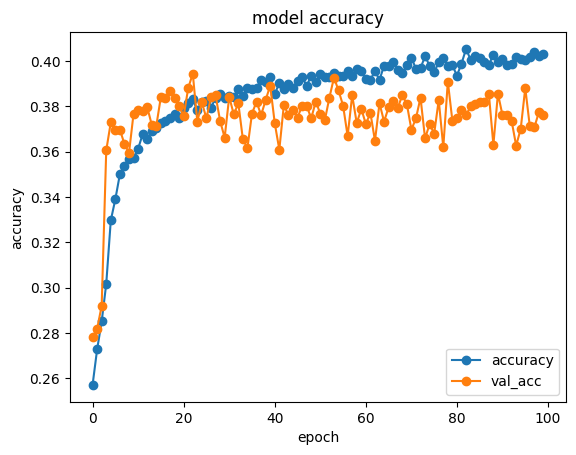

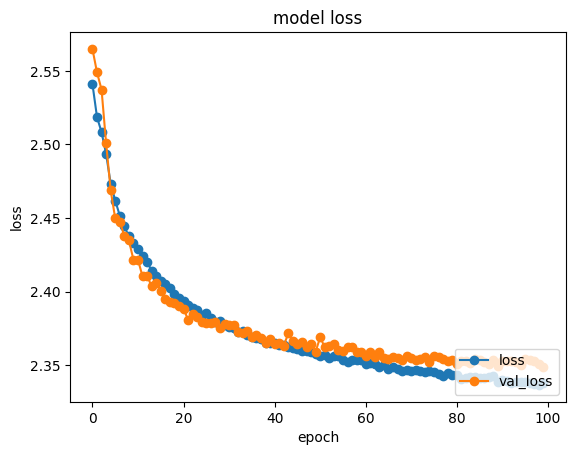

In [10]:
# loss 遷移のプロット

import matplotlib.pyplot as plt

plot_history(history)

In [ ]:
# 楽曲の出力

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model
import soundfile as sf

model = load_model("../data/models/" + model_name)
file_name = "out_" + model_name
num_clips = 10

def add_fade(x, fadetime, sr):
    ft_len = int(fadetime*sr)
    r = np.arange(0, ft_len)*np.pi/ft_len
    w_fo = (0.5+0.5*np.cos(r))**0.5
    w_fi = (0.5-0.5*np.cos(r))**0.5
    
    x[0:ft_len]        *= w_fi
    x[clip_size-ft_len::] *= w_fo
    return x

def gen_xfade(x_pre, x_next, fadetime, sr):
    ft_len = int(fadetime*sr)
    if x_pre is None:
        xfade = x_next
    else:
        x_pre_begin = x_pre[:x_pre.shape[0] - ft_len]
        x_pre_end = x_pre[x_pre.shape[0] - ft_len:]
        x_pre_len = clip_size
        x_next_len = clip_size
        x_pre_len -= ft_len
        x_next_len -= ft_len
        xfade = np.concatenate((x_pre_begin, np.concatenate((x_pre_end, np.zeros(x_next_len))) + x_next))
    return xfade

def create_music(fname):
    first_index = np.random.randint(0, len(cqt_chromas))
    predict_index = first_index
    out = None
    
    for i in range(num_clips):
        print("-- generate " + str(i + 1) + " / " + str(num_clips))
        predict = model.predict(np.array([cqt_chromas[predict_index, :-1]]))

        index = 0
        similar_index = 0
        cos_sim = -1
        for cqt_chroma in cqt_chromas[:, 0:1]:
            tmp_sim = cosine_similarity(predict, cqt_chroma) 
            if tmp_sim > cos_sim:
                cos_sim = tmp_sim
                similar_index = index
            index += 1

        print("cos_sim: " + str(cos_sim))
        print("predict: " + str(predict))
        print("cqt_chromas[similar_index]: " + str(cqt_chromas[similar_index, 0]))
        print("similar_index: " + str(similar_index))
        print("--")

        predict_index = similar_index

        tmp = add_fade(clips[predict_index], 0.1, SAMPLING_RATE)
        out = gen_xfade(out, tmp, 0.1, SAMPLING_RATE)
    
    
    sf.write(fname, out, SAMPLING_RATE, subtype="PCM_16")

fname = "../data/out/" + file_name + "_1.wav"
print("creating " + fname + " ...")
create_music(fname)

fname = "../data/out/" + file_name + "_2.wav"
print("creating " + fname + " ...")
create_music(fname)

fname = "../data/out/" + file_name + "_3.wav"
print("creating " + fname + " ...")
create_music(fname)

creating ../data/out/out_cqt_chroma_batch64_e100_1.wav ...
-- generate 1 / 10
1/1 [==============================] - 0s 55ms/step
cos_sim: [[0.9415602]]
predict: [[0.06154038 0.15525076 0.06792969 0.0773858  0.06667729 0.08178809
  0.09232614 0.0808564  0.05990656 0.05742072 0.05744188 0.04334892
  0.04368022 0.05444717]]
cqt_chromas[similar_index]: [0.0056797  0.0078125  0.         0.00509986 0.0037737  0.00505125
 0.00534057 0.00411136 0.00118024 0.00256417 0.00276613 0.00309358
 0.00216477 0.00162569]
similar_index: 5698
--
-- generate 2 / 10
1/1 [==============================] - 0s 15ms/step
cos_sim: [[0.941775]]
predict: [[0.06182742 0.15694566 0.06821553 0.07778611 0.0666877  0.08206881
  0.09233643 0.08104831 0.05996111 0.05729355 0.05743953 0.04329954
  0.04132247 0.05376783]]
cqt_chromas[similar_index]: [0.0056797  0.0078125  0.         0.00509986 0.0037737  0.00505125
 0.00534057 0.00411136 0.00118024 0.00256417 0.00276613 0.00309358
 0.00216477 0.00162569]
similar_index: 56

1/1 [==============================] - 0s 15ms/step
cos_sim: [[0.941775]]
predict: [[0.06182742 0.15694566 0.06821553 0.07778611 0.0666877  0.08206881
  0.09233643 0.08104831 0.05996111 0.05729355 0.05743953 0.04329954
  0.04132247 0.05376783]]
cqt_chromas[similar_index]: [0.0056797  0.0078125  0.         0.00509986 0.0037737  0.00505125
 0.00534057 0.00411136 0.00118024 0.00256417 0.00276613 0.00309358
 0.00216477 0.00162569]
similar_index: 5698
--
-- generate 9 / 10
1/1 [==============================] - 0s 16ms/step
